In [2]:
!pip install playwright nest-asyncio pandas
!playwright install


# !pip install playwright nest-asyncio pandas

- Installs Playwright (a browser automation library).
- Installs nest-asyncio (allows running async code in environments like Jupyter notebooks).
- Installs pandas (a data analysis library).

# !playwright install

- Downloads and installs the necessary browser binaries 
- (Chromium, Firefox, WebKit) for Playwright to automate them.

In [3]:
import nest_asyncio
import asyncio
import re
import random
from datetime import datetime
from playwright.async_api import async_playwright
import pandas as pd

# Allows asyncio to work properly in Jupyter Notebook
nest_asyncio.apply()

## import nest_asyncio
- Allows asyncio to work properly in Jupyter Notebook.
- Without this, asyncio.run() may throw errors in Jupyter.

## import asyncio
- Enables asynchronous programming in Python.
- Required to run async functions like get_tweets_and_dates().

## import random
- Used for adding random delays (e.g., random.randint(5, 10)).
- Helps avoid detection when scraping.

## from datetime import datetime
- Used for date formatting and conversions (e.g., ISO format → readable format).

## from playwright.async_api import async_playwright
- Imports Playwright asynchronously to control Chromium for web scraping.
- Needed to launch a browser, load Twitter, and extract tweets.

## import pandas as pd (Optional)
- Used for saving data as a DataFrame or CSV.

## nest_asyncio.apply() 
- ensures Playwright runs in Jupyter Notebook without issues.

In [51]:
import nest_asyncio
import asyncio
import re
import string
import time
import random
from datetime import datetime
from playwright.async_api import async_playwright
import pandas as pd 

nest_asyncio.apply()

keywords = [
    "Petronas layoffs", 
    "Petronas downsizing", 
    "Petronas retrenchment",
    "Petronas job cuts", 
    "Petronas restructuring",  
    "Petronas rightsizing", 
    "Petronas VSS", 
    "Petronas laying off"
]

# Removes extra spaces
# Deletes links (URLs)
# Returns a cleaner version of the tweet

def clean_tweet(tweet):
    tweet = tweet.strip()
    tweet = re.sub(r"\s+", " ", tweet)  # Replace multiple spaces with single space
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    return tweet

# async def get_tweets_and_dates searches tweets based on a given keyword. It will extract up to 500 tweets.
# Opens a persistent browser session (so we stay logged in). CHROMIUM
# Uses a fake user-agent to act like a real person.
# Runs in a visible browser (headless=False) so we can log in manually.

async def get_tweets_and_dates(keyword, max_tweets=500):
    async with async_playwright() as p:
        user_data_dir = "twitter_session"
        browser = await p.chromium.launch_persistent_context(
            user_data_dir, headless=False,
            user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36"
        )
        
# Converts spaces (' ') in the keyword to %20 (URL encoding).
# Opens Twitter’s search page with live tweets.

        page = browser.pages[0]
        url = f"https://twitter.com/search?q={keyword.replace(' ', '%20')}&src=typed_query&f=live"
        await page.goto(url)

# If Twitter asks for a login, it pauses until you log in manually.       
        
        while "login" in page.url:
            print("Waiting for login... Please log in manually.")
            await asyncio.sleep(random.uniform(5, 10))
#             await page.wait_for_timeout(random.randint(2000, 5000))

        print("Login detected, starting tweet extraction...")

# Creates empty lists to store tweet data.
# Limits scrolling to 100 times.
# Only collects tweets from December 2024 onwards.  
    
        collected_dates, collected_tweets, collected_usernames = [], [], []
        max_scrolls = 100
        min_date = datetime(2024, 12, 1)

        for _ in range(max_scrolls):
            try:
                await page.wait_for_selector("time", timeout=9000)

# Finds all tweet containers in the page.                
                
                tweet_articles = await page.locator("article").all()  # Get all tweet containers
                
                prev_count = len(collected_tweets)

# Waits for tweet text to fully load.                
# Wait for tweet text to load                
                for article in tweet_articles:
                    try:
                        await article.locator("div[data-testid='tweetText']").first.wait_for(timeout=5000)

# Joins all parts of the tweet (useful if there's a quoted tweet).
# Collect all possible tweet texts (handles quoted tweets)                                            
                        
                        tweet_texts = await article.locator("div[data-testid='tweetText']").all_text_contents()
                        cleaned_tweet = " ".join(tweet_texts).strip()

# Extracts the username of the tweet author.
# Extract username safely, avoiding strict mode violation                
                        
                        username = await article.locator("div[data-testid='User-Name']").first.inner_text()

# Finds the tweet’s timestamp and converts it into a datetime format.            
# Extract tweet date safely, avoiding strict mode violation            
                        
                        date_element = await article.locator("time").first.get_attribute("datetime")
                        tweet_date = datetime.fromisoformat(date_element[:-1]) if date_element else None

# Saves tweets that are not duplicates
# Ensures tweets are from December 2024 onwards                
                
                        if tweet_date and tweet_date >= min_date:
                            if cleaned_tweet and cleaned_tweet not in collected_tweets:
                                collected_tweets.append(cleaned_tweet)
                                collected_dates.append(tweet_date)
                                collected_usernames.append(username)
                                print(f"✅ {tweet_date} - {username}: {cleaned_tweet[:50]}...")

                    except Exception as e:
                        print(f"❌ Skipping tweet due to error: {e}")

# Scrolls down to load more tweets.
# Random sleep time (to mimic real users & avoid bans). Random between 15s to 45s                        
                        
                await page.evaluate("window.scrollTo(0, document.body.scrollHeight)")
                await asyncio.sleep(random.uniform(15, 45))

# If no new tweets appear after scrolling, it stops scrolling.            
            
                if len(collected_tweets) == prev_count:
                    print("No new tweets detected. Stopping scroll.")
                    break
            
            except Exception as e:
                print(f"❌ Error during extraction: {e}")
                break

# Closes the browser and returns tweets, timestamps, and usernames.                
                
        await browser.close()
        return collected_dates, collected_tweets[:max_tweets], collected_usernames[:max_tweets]

# Loops through each keyword, searches Twitter, and stores results.
# Run tweet collection for each keyword
results = {}
for keyword in keywords:
    print(f"Fetching tweets for: {keyword}...")
    dates, tweets, usernames = asyncio.run(get_tweets_and_dates(keyword))
    results[keyword] = {"dates": dates, "tweets": tweets, "usernames": usernames}
    print(f"✅ Collected {len(tweets)} tweets for {keyword}\n")

# Prints 3 sample tweets for each keyword.
# Print results
for keyword, data in results.items():
    print(f"\n🔍 Keyword: {keyword}")
    limit = min(3, len(data["tweets"]))
    print("📅 Timestamps:", data["dates"][:limit])
    print("👤 Usernames:", data["usernames"][:limit])
    print("💬 Tweets:", data["tweets"][:limit])


Fetching tweets for: Petronas layoffs...
Login detected, starting tweet extraction...
✅ 2025-03-01 05:05:46 - Asian Strategy & Leadership Institute (ASLI)
@asli_myofficial
·
Mar 1: 1) Petronas to Undergo Workforce Rightsizing in 20...
✅ 2025-02-20 02:55:57 - The Futurizts
@TheFuturizts
·
Feb 20: 2. This wasn’t due to poor worker performance but ...
✅ 2025-02-17 13:03:22 - New Straits Times
@NST_Online
·
Feb 17: #NSTnation Kalam Salan (PN-Sabak Bernam) sought cl...
✅ 2025-02-14 11:33:19 - Mojo Jojo
@MojoJojoMY
·
Feb 14: How did this harm PETRONAS' reputation? Was the vi...
✅ 2025-01-10 00:48:08 - Max TweetLimit
@_maxxlr8
·
Jan 10: But I baru nampak Ada cakap ni old news.

I dengar...
✅ 2025-01-09 12:14:50 - Afif
@afifster
·
Jan 9: Fake news. Petronas hasn't started the layoffs. De...
✅ 2025-01-04 00:30:52 - Ridhwandowski / رودي
@ridhwandowski
·
Jan 4: Dh 2025 ni masih ada org bangang percaya Najib suc...
✅ 2025-01-03 08:00:46 - Qistina Nadia D.
@qistina_nadia_
·
Jan 3: Instead of going 

# Final Summary
## ✅ This script automatically logs into Twitter, searches for tweets based on specific Petronas-related keywords, and extracts relevant data (timestamps, usernames, and tweets).
## ✅ It avoids scraping duplicates, limits tweets by date (from Dec 2024), and mimics real user behavior to avoid detection.
## ✅ Perfect for sentiment analysis on Petronas downsizing!

In [52]:
import csv

def save_to_csv(results, filename="tweets_v5.csv"):
    
    with open(filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Keyword", "Timestamp", "Username", "Tweet"])
        
        for keyword, data in results.items():
            for date, username, tweet in zip(data["dates"], data["usernames"], data["tweets"]):
                writer.writerow([keyword, date, username, tweet])

    print(f"✅ Data saved to {filename}")

# Call this function after collecting tweets
save_to_csv(results, filename="/Users/macintosh/Desktop/Naqib Zainal/Data/Project/tweets_v5.csv")  # Linux/Mac


✅ Data saved to /Users/macintosh/Desktop/Naqib Zainal/Data/Project/tweets_v5.csv


# Saving Scraped Tweets to CSV 

## 1️⃣ Opening a CSV File
- We create (or overwrite) a CSV file named tweets_v5.csv to store the data.
- The file is opened in write mode ("w") with UTF-8 encoding to handle special characters.

## 2️⃣ Writing the Header
- We define column names: Keyword, Timestamp, Username, and Tweet.
- This helps keep the data structured for easy reading and analysis.

## 3️⃣ Storing Tweet Data
- We loop through the results dictionary, where tweets are stored under each keyword.
- Each row contains the keyword, tweet timestamp, username, and the tweet itself.

## 4️⃣ Completion Message
- Once all tweets are saved, a confirmation message is printed:
- ✅ Data saved to tweets_v5.csv

In [53]:
import pandas as pd

def save_to_excel(results, filename="tweets_v5.xlsx"):
    # Prepare data for DataFrame
    data = []
    for keyword, details in results.items():
        for date, username, tweet in zip(details["dates"], details["usernames"], details["tweets"]):
            data.append([keyword, date, username, tweet])

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["Keyword", "Timestamp", "Username", "Tweet"])

    # Save to Excel
    df.to_excel(filename, index=False, encoding="utf-8")

    print(f"✅ Data saved to {filename}")

# Call after collecting tweets
save_to_excel(results, filename="/Users/macintosh/Desktop/Naqib Zainal/Data/Project/tweets_v5.xlsx")  # Linux/Mac

✅ Data saved to /Users/macintosh/Desktop/Naqib Zainal/Data/Project/tweets_v5.xlsx


# Saving Scraped Tweets to Excel 

## 1️⃣ Structuring the Data
- We initialize an empty list data to store each tweet’s details.
- We loop through results, extracting:
- The keyword used for search
- The timestamp of the tweet
- The username of the person who posted it
- The tweet content itself
- Each tweet’s details are added to data as a row.

## 2️⃣ Converting to a DataFrame
- We use pandas to create a DataFrame (df) from the data list.
- Column names: Keyword, Timestamp, Username, Tweet.

## 3️⃣ Saving to an Excel File
- We save df as an Excel file (tweets_v5.xlsx).
- The index=False argument prevents adding an extra column for row numbers.
- UTF-8 encoding ensures all text is correctly stored.

## 4️⃣ Completion Message
- A success message is printed once the file is saved:
- ✅ Data saved to tweets_v5.xlsx


In [32]:
!pip install vaderSentiment

/Users/macintosh/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


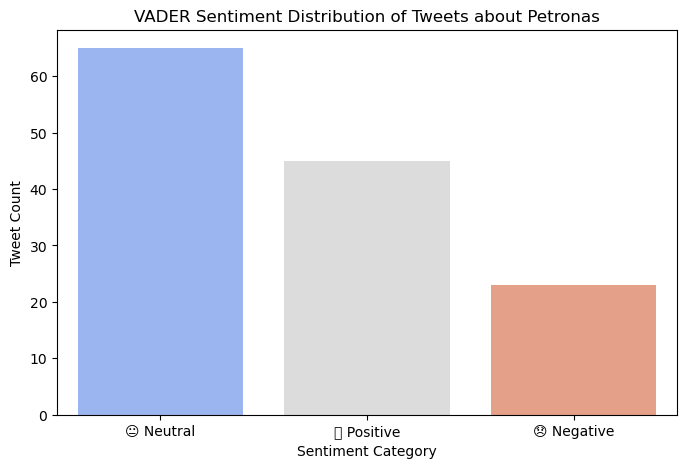

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ✅ Load CSV File (Ensure the path is correct)
file_path = "/Users/macintosh/Desktop/Naqib Zainal/Data/Project/Twitter scraping/tweets_v5.csv"
df = pd.read_csv(file_path)

# ✅ Convert 'Timestamp' to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# This tool assigns sentiment scores based on words and context.
# ✅ Initialize VADER Sentiment Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# ✅ Function to analyze sentiment using VADER
def get_vader_sentiment(tweet):
    score = vader_analyzer.polarity_scores(tweet)["compound"]
    if score >= 0.05:
        return "🙂 Positive"
    elif score <= -0.05:
        return "😞 Negative"
    else:
        return "😐 Neutral"
    
# 📌 We apply the function to each tweet and store the results in a new column
# ✅ Apply VADER sentiment analysis
df["VADER_Sentiment"] = df["Tweet"].apply(get_vader_sentiment)

# 📊 **VADER Sentiment Distribution Graph BARCHART**
plt.figure(figsize=(8, 5))
sns.barplot(x=df["VADER_Sentiment"].value_counts().index, 
            y=df["VADER_Sentiment"].value_counts().values, palette="coolwarm")
plt.xlabel("Sentiment Category")
plt.ylabel("Tweet Count")
plt.title("VADER Sentiment Distribution of Tweets about Petronas")
plt.show()


/Users/macintosh/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


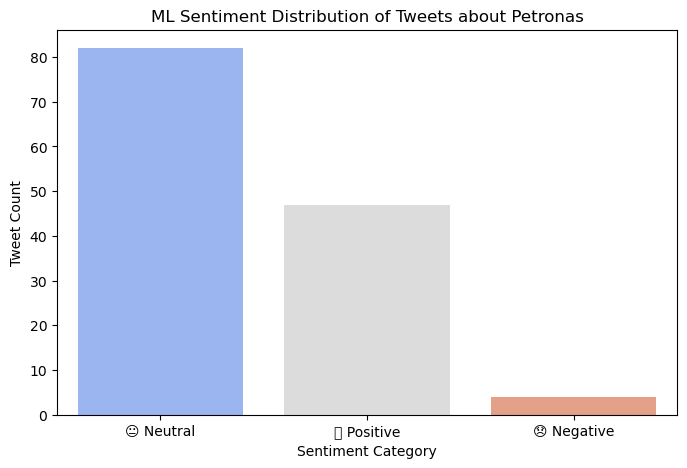

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# ✅ Label Encoding for ML model
# ✔ 🙂 Positive → 1
# ✔ 😞 Negative → -1
# ✔ 😐 Neutral → 0
# This transforms our dataset into a format the ML model can understand.

label_mapping = {"🙂 Positive": 1, "😞 Negative": -1, "😐 Neutral": 0}
df["Sentiment_Label"] = df["VADER_Sentiment"].map(label_mapping)

# ✅ Split dataset for ML Training
# ✔ X_train & y_train → Used to train the model
# ✔ X_test & y_test → Used to evaluate accuracy
# This ensures our model learns from past data and can predict on new, unseen tweets.

X_train, X_test, y_train, y_test = train_test_split(df["Tweet"], df["Sentiment_Label"], test_size=0.2, random_state=42)

# ✅ TF-IDF + Logistic Regression Pipeline
# ✔ TF-IDF: Extracts the most important words from tweets
# ✔ Logistic Regression: A simple yet powerful model for text classificatio
# ✔ max_features=5000 → Uses top 5,000 words (adjust based on dataset size).
# ✔ max_iter=1000 → Trains model for up to 1,000 steps (increase if needed).

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, stop_words="english")),
    ("classifier", LogisticRegression(max_iter=1000))
])

# ✅ Train the ML model
# The model learns sentiment patterns from real-world tweets about Petronas layoffs.

pipeline.fit(X_train, y_train)

# ✅ Predict sentiment using ML model
# This adds a new column with ML-based sentiment predictions (Positive, Negative, or Neutral).

df["ML_Sentiment_Label"] = pipeline.predict(df["Tweet"])

# ✅ Convert ML labels back to sentiment text
# map them back to readable labels:
    
reverse_label_mapping = {1: "🙂 Positive", -1: "😞 Negative", 0: "😐 Neutral"}
df["ML_Sentiment"] = df["ML_Sentiment_Label"].map(reverse_label_mapping)

# 📊 **ML Sentiment Distribution Graph**
# We plot a bar chart to see the number of Positive, Negative, and Neutral tweets:

plt.figure(figsize=(8, 5))
sns.barplot(x=df["ML_Sentiment"].value_counts().index, 
            y=df["ML_Sentiment"].value_counts().values, palette="coolwarm")
plt.xlabel("Sentiment Category")
plt.ylabel("Tweet Count")
plt.title("ML Sentiment Distribution of Tweets about Petronas")
plt.show()


# 🔍 Machine Learning Sentiment Analysis: Step-by-Step Breakdown

- Now, let's take sentiment analysis a step further! Instead of relying solely on VADER (a rule-based approach), 

- we'll train a Machine Learning (ML) model to classify tweets more accurately.

- We’ll use Logistic Regression with TF-IDF (Term Frequency-Inverse Document Frequency) to analyze sentiment patterns

## ✅ TF-IDF + Logistic Regression Pipeline
    ("tfidf", TfidfVectorizer(max_features=5000, stop_words="english")),
    ("classifier", LogisticRegression(max_iter=1000))

## 1️⃣ max_features=5000 in TfidfVectorizer
- 📌 What it does:
- The TfidfVectorizer converts text into a numerical format (TF-IDF scores).It selects the top 5,000 most important words from all tweets (based on frequency).Words outside the top 5,000 are ignored.

- 📌 Why 5,000?
- This limits memory usage and speeds up training.
- A higher number (e.g., 10,000) captures more vocabulary but increases computation time.
- A lower number (e.g., 1,000) makes training faster but loses important words.
- 📌 Can you change it?
- Yes! If your dataset is large, try 10,000 or 20,000. If it's small, reduce it to 1,000 or 2,000.

## 2️⃣ max_iter=1000 in LogisticRegression
- 📌 What it does:
- Logistic Regression uses an optimization algorithm (Gradient Descent) to learn sentiment patterns.max_iter=1000 means the algorithm will run up to 1,000 iterations to find the best model.

- 📌 Why 1,000?
- If set too low (e.g., 100 or 200), training might stop before reaching the best solution.
- If set too high (e.g., 5000), it may waste time if the model already converged.
- 1,000 is a good balance for most text classification tasks.
- 📌 Can you change it?

- If you see "ConvergenceWarning: Solver did not converge", try increasing it (e.g., 2000 or 5000).
- If training is slow, reduce it to 500 (but check accuracy).

## 🔹 TL;DR
- ✔ max_features=5000 → Uses top 5,000 words (adjust based on dataset size).
- ✔ max_iter=1000 → Trains model for up to 1,000 steps (increase if needed).

✅ Excel file saved at: /Users/macintosh/Desktop/Naqib Zainal/Data/Project/SentimentAnalysis_v6.xlsx

🔹 ML Model Performance:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         8
           0       0.50      0.83      0.62        12
           1       0.14      0.14      0.14         7

    accuracy                           0.41        27
   macro avg       0.21      0.33      0.26        27
weighted avg       0.26      0.41      0.31        27



/Users/macintosh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macintosh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macintosh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

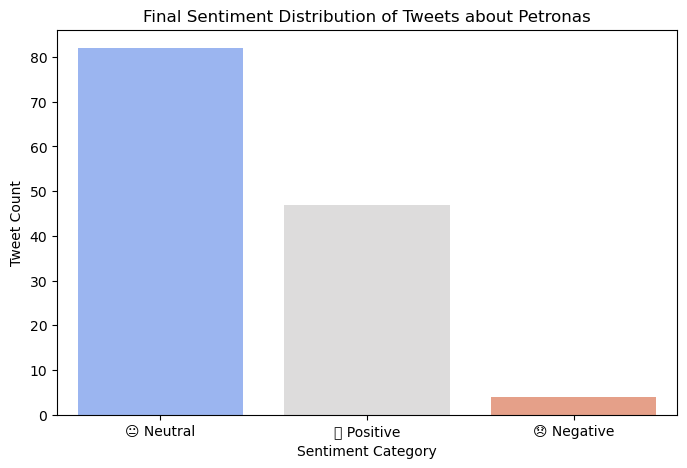

In [64]:
# ✅ Combine VADER + ML results (if both agree, use the sentiment; if they differ, prioritize ML)

# 📌 What It Does:
# If VADER & ML agree, keep that sentiment.
# If they disagree, prioritize ML Sentiment over VADER.
# Uses apply() to check each row and assign the final sentiment.

# 📌 Why Prioritize ML?
# ML is trained on your dataset, making it more context-aware.
# VADER is rule-based and can misinterpret sarcasm or complex phrases.

df["Final_Sentiment"] = df.apply(lambda row: row["ML_Sentiment"] if row["VADER_Sentiment"] != row["ML_Sentiment"] else row["VADER_Sentiment"], axis=1)

# ✅ Save to Excel
output_path = "/Users/macintosh/Desktop/Naqib Zainal/Data/Project/SentimentAnalysis_v6.xlsx"
df.to_excel(output_path, index=False)

print(f"✅ Excel file saved at: {output_path}")

# ✅ Display performance of ML model
y_pred = pipeline.predict(X_test)
print("\n🔹 ML Model Performance:\n")
print(classification_report(y_test, y_pred))

# 📊 **Final Sentiment Distribution Graph**
plt.figure(figsize=(8, 5))
sns.barplot(x=df["Final_Sentiment"].value_counts().index, 
            y=df["Final_Sentiment"].value_counts().values, palette="coolwarm")
plt.xlabel("Sentiment Category")
plt.ylabel("Tweet Count")
plt.title("Final Sentiment Distribution of Tweets about Petronas")
plt.show()


# 📌 Key Metrics to Watch:

# Precision: How often positive/negative predictions are correct.
# Recall: How well the model captures all positive/negative cases.
# F1-score: The balance between precision & recall (higher is better).

# 📌 What to Look For:
# ✔ High Precision & Recall (>0.8 is good) → Model performs well.
# ❌ Low Recall (e.g., 0.5) → Some sentiments are missing.

# 1️⃣ Precision (How Careful the Model Is)
Think of precision like a student raising their hand only when they’re 100% sure they know the answer.

For example:

The model said 10 tweets were Positive, but only 5 were actually Positive → That’s 50% precision (5/10 correct).
If precision is low, the model is guessing too much and making lots of mistakes.
If precision is high, the model is being very careful and mostly correct when making predictions.
Right now, our model struggles with Positive and Negative tweets because it isn't very precise—it keeps guessing wrong.

# 2️⃣ Recall (How Much the Model Notices)
Think of recall like a student who tries to answer as many questions as possible, even if they sometimes get them wrong.

For example:

There were 10 actual Positive tweets, but the model only caught 3 of them → That’s 30% recall (3/10 found).
If recall is low, the model misses a lot of things (it doesn’t recognize many Positive tweets).
If recall is high, the model notices almost everything, but it might still make mistakes.
Right now, the model notices Neutral tweets well (83% recall), but struggles with Positive and Negative ones.

# 3️⃣ F1-Score (The Balance Between Precision & Recall)
Think of F1-score as a student who balances being careful (precision) and noticing everything (recall).

If the model is too careful (high precision, low recall), it won’t make many predictions.
If the model is too reckless (high recall, low precision), it will make lots of wrong guesses.
A high F1-score means the model is both accurate and aware.
Since our model has low F1-scores for Positive and Negative tweets, it means it’s struggling to balance being careful and being aware.

# 🔹 So, What Do the Numbers Mean?
Low precision? The model guesses too much and is often wrong.
Low recall? The model misses a lot of important tweets.
Low F1-score? The model is struggling overall and needs improvement.
High accuracy (closer to 100%)? The model is doing great!
41% accuracy (like ours)? The model is still learning and needs better training data.

# EXAMPLE 1
## 🔹 Class Breakdown: What’s Happening?
The model is classifying sentiment into three categories:

Negative (-1)
Neutral (0)
Positive (1)
Here’s how the model performed for each category:

1️⃣ Negative (-1) Sentiment
Precision = 0.00 → The model never correctly predicted a negative tweet.
Recall = 0.00 → Out of 8 negative tweets, it caught none.
F1-Score = 0.00 → The model completely failed for negatives.
📉 Problem: The model does not recognize negative tweets at all, meaning it has serious issues distinguishing them from neutral or positive ones.

# EXAMPLE 2
## 🔹 Class Breakdown: What’s Happening?
2️⃣ Neutral (0) Sentiment
Precision = 0.50 → Half of the model’s neutral predictions were correct.
Recall = 0.83 → Out of 12 actual neutral tweets, it correctly classified 83%.
F1-Score = 0.62 → Decent balance between precision and recall.
📈 Observation: The model does well at identifying neutral tweets but still makes some incorrect guesses.

# EXAMPLE 3
## 🔹 Class Breakdown: What’s Happening?
3️⃣ Positive (1) Sentiment
Precision = 0.14 → Only 14% of the model’s positive predictions were correct.
Recall = 0.14 → It only caught 14% of actual positive tweets.
F1-Score = 0.14 → The model struggles with positives.
📉 Problem: The model barely recognizes positive tweets, meaning it isn’t distinguishing them well from neutral/negative tweets.

# 🔹 Overall Model Performance

Accuracy 41% The model gets about 41% of predictions right. This is low.
Macro Avg Precision 21%	On average, only 21% of the predictions are correct.
Macro Avg Recall 33% The model catches about 33% of actual cases.
Macro Avg F1-Score 26% The model is struggling to balance precision and recall.

- 📢 So, Is This Model Okay?
- 🔴 No, the model is NOT performing well.

- Biggest Issue: It completely fails at detecting negative sentiment (0% recall and precision).
- Neutral tweets are the only ones it predicts somewhat well (but still has errors).
- Positive sentiment detection is very weak (only 14% correct).
- Overall accuracy (41%) is too low for a reliable model.

# JUSTIFICATION ON LOW

## The small dataset (only 120+ tweets) is a major reason why the model isn't performing well.
- Machine learning models need a lot of data to recognize patterns properly.
- With only ~120 tweets, the model doesn’t have enough examples to learn the differences between positive, neutral, and negative twe

## 🔹 What Can You Do?
- ✅ Get More Tweets
Try scraping a larger dataset (e.g., past 6–12 months).
Aim for at least a few thousand tweets for better learning.

- ✅ Use Pretrained Sentiment Models
Instead of training from scratch, try models like BERT or RoBERTa, which are already trained on massive datasets.
This way, your model benefits from general sentiment knowledge even with fewer tweets.

- ✅ Data Augmentation (if more data isn’t possible)
Use synonym replacement or paraphrasing techniques to create more training samples from existing ones.

- ✅ Combine ML with VADER More Effectively
- Since VADER is rule-based, it might handle small datasets better than ML alone.
Consider tweaking the final sentiment decision-making process (e.g., using VADER unless ML confidence is high).


# 🔹 Final Thought
Your model isn't necessarily "bad"—it's just data-starved. A larger dataset will improve accuracy significantly. 🚀